# Spin dynamics

In [1]:
## imports
 
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import *

## System described here

We want to describe our system as it will be at first on the benchtop version.
We have the laser and the rf field $B_1$ along the z axis, the field to measure $B_0$ in the  yz-plane (according to [1]).

$$ \partial_t \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} = \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} \wedge \begin{pmatrix} 0 \\ \gamma B_0 \sin(\theta) \\ \gamma B_0 \cos(\theta) + \gamma B_{rf}\cos(\omega_{rf} t) \end{pmatrix} - \Gamma \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} + R_{op} \begin{pmatrix}- S_x \\ - S_y \\ S_0-M_z\end{pmatrix} $$


$$
\partial_t \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} =
\begin{pmatrix} 
\left(\gamma B_0 \cos(\theta) +\gamma B_{rf} \cos(\omega_{rf} t) \right) S_y - \gamma B_0\sin(\theta) S_z  \\ 
- \left( \gamma B_0 \cos(\theta) + \gamma B_{rf} \cos(\omega_{rf} t) \right) S_x  \\ 
\gamma B_0 \sin(\theta) S_x 
\end{pmatrix}
- \Gamma \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix}
+ R_{op} \begin{pmatrix} - S_x \\ - S_y \\ S_0 - S_z \end{pmatrix}.
$$




With :
- $\hat{S}$ : the spin operator
- $B_0$ : the bias field, i.e. the field we want to measure, assumed here as DC
- $B_{rf}$ : the intensity of the RF field to pump the spins
- $\gamma$ : the gyromagnetic ratio of $^{87}R_b$
- $\theta$ : the angle between the bias field $\vec{B_0}$ and the basis
- $\Gamma$ : the relaxation rate (assumed as equal to $\Gamma_{SE} + \Gamma_{SD} + \Gamma_{wall}$)
- $R_{op}$ : the optical pumping rate; $R_{op} = \sigma_{abs} \phi_{opt}$

In [2]:
## Constants
gamma = 7e9    # Gyromagnetic ratio (Hz/T)
sigma = 1.082e-13 #m^2 from Table 7, [2]
mu_B = 9.2740100657e-24 # J/T Bohr Magneton

## Parameters
Gamma = 2000    # Relaxation rate (Hz)
R_op = 3e5   # Optical pumping rate (Hz)

B_0 = 100e-7    # Static field intensity (Tesla)
B_1 = 1e-3      # RF field intensity (Tesla)
theta = 45*np.pi/180

P_laser = 0.2e-3 # Laser power (W)
beam_diameter = 1e-3 # self-explanatory (m)

P = 3e-1        # Cell pressure (Pa)
V = 3e-3*3e-3*1.9e-3 # Cell volume (m^3)
z_cell = 1.9e-2 # Cell length (m)
T = 273.15+60   # Cell temperature (K)

## Derived parameters
omega = gamma * B_0   # Frequency of the RF field (Hz)
I_0 = P_laser/(np.pi*(beam_diameter/2)**2) # Laser intensity before the cell (W/m²)
n = P/(k*T)     # Rb density (m^-3)
N = P*V/(k*T) # Number of particles
S_0 = 1      # maximum magnetization

$$
\partial_t \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} =
\begin{pmatrix} 
\left(\gamma B_0 \cos(\theta) +\gamma B_{rf} \cos(\omega_{rf} t) \right) S_y - \gamma B_0\sin(\theta) S_z  \\ 
- \left( \gamma B_0 \cos(\theta) \gamma B_{rf} \cos(\omega_{rf} t) \right) S_x  \\ 
\gamma B_0 \sin(\theta) S_x 
\end{pmatrix}
- \Gamma \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix}
+ R_{op} \begin{pmatrix} - S_x \\ - S_y \\ S_0 - S_z \end{pmatrix}.
$$

In [ ]:
def bloch_equations(t, S, gamma, B_0, B_1, omega, Gamma, R_op, S_0):
    Sx, Sy, Sz = S
    cos_omega_t = np.cos(omega * t)
    term1 = B_1 * cos_omega_t + B_0 * np.cos(theta)
    term2 = B_0 * np.sin(theta)

    dSxdt = gamma * term1 * Sy - gamma * term2 * Sz - (Gamma + R_op) * Sx
    dSydt =  - gamma * term1 * Sx - (Gamma + R_op) * Sy
    dSzdt = gamma * term2 * Sx - (Gamma) * Sz + R_op * (S_0 - Sz)
    return [dSxdt, dSydt, dSzdt]

def solve_bloch_equations(initial_state, t_span, t_eval, gamma, B_0, B_1, omega, Gamma, R_op, S_0):
    solution = solve_ivp(
        bloch_equations,
        t_span,
        initial_state,
        method='BDF',  
        t_eval=t_eval,
        args=(gamma, B_0, B_1, omega, Gamma, R_op, S_0)
    )
    return solution

initial_state = [0, 0, 0]
t_span = [0, 1e-1]
sampling_rate = int(3*gamma*B_0) #adjust to have a frequency that allows me to detect the oscillation
t_eval = np.linspace(t_span[0], t_span[1], sampling_rate)  

solution = solve_bloch_equations(initial_state, t_span, t_eval, gamma = gamma, B_0 = B_0, B_1 = B_1, omega = omega, Gamma = Gamma, R_op = R_op, S_0=S_0)

t = solution.t
Sx, Sy, Sz = solution.y

print(f"FinalSx: {Sx[-1]:.4f}")
print(f"Final Sy: {Sy[-1]:.4f}")
print(f"Final Sz: {Sz[-1]:.4f}")

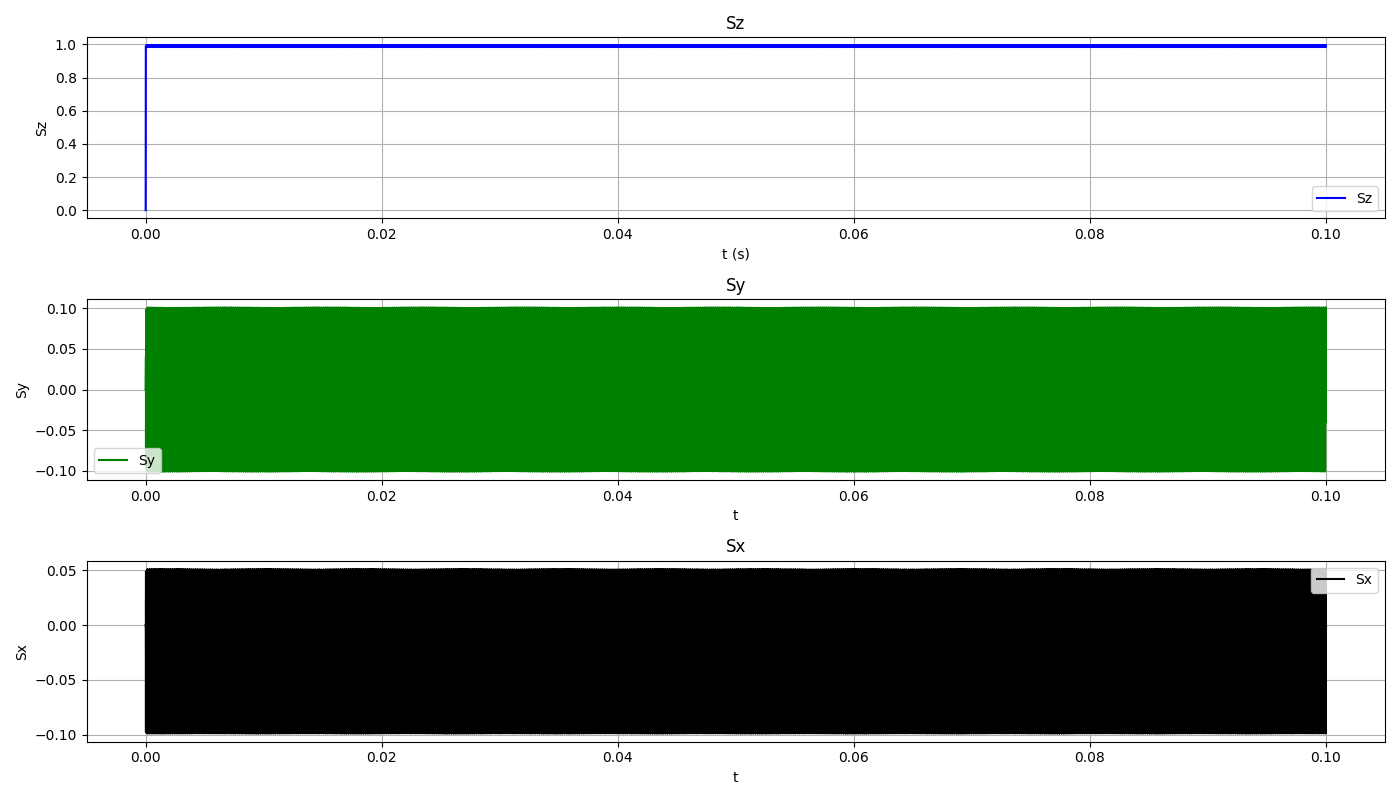

In [ ]:
%matplotlib widget
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))

points_to_skip = 0

axes[0].plot(t[points_to_skip:], Sz[points_to_skip:], color='blue', label='Sz')
axes[0].set_title('Sz')
axes[0].set_xlabel('t (s)')
axes[0].set_ylabel('Sz')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(t[points_to_skip:], Sy[points_to_skip:], color='green', label='Sy')
axes[1].set_title('Sy')
axes[1].set_xlabel('t')
axes[1].set_ylabel('Sy')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t[points_to_skip:],Sx[points_to_skip:], color='black', label='Sx')
axes[2].set_title('Sx')
axes[2].set_xlabel('t')
axes[2].set_ylabel('Sx')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()

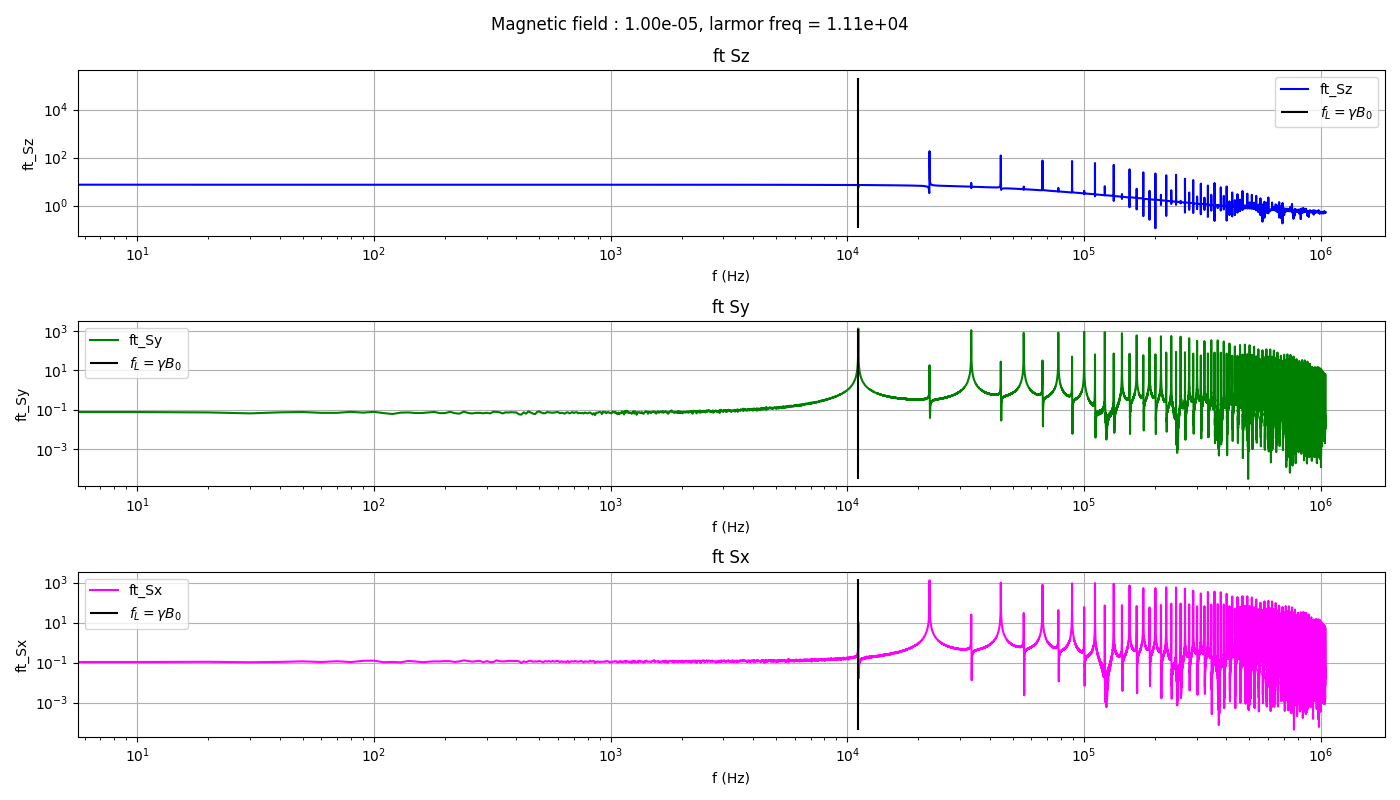

In [ ]:
dt = t_eval[1]-t_eval[0]
freq = np.fft.rfftfreq(len(t_eval[points_to_skip:]), d=dt)
#freq_shifted = np.abs(np.fft.fftshift(freq))

ft_Sz = np.abs(np.fft.rfft(Sz[points_to_skip:]))
ft_Sy = np.abs(np.fft.rfft(Sy[points_to_skip:]))
ft_Sx = np.abs(np.fft.rfft(Sx[points_to_skip:]))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))

fig.suptitle('Magnetic field : {:.2e}, larmor freq = {:.2e}'.format(B_0, gamma*B_0/(2*np.pi)))

axes[0].plot(freq, ft_Sz, color='blue', label='ft_Sz')
axes[0].vlines(gamma*B_0/(2*np.pi), min(ft_Sz), max(ft_Sz), color = 'k', label='$f_{L} = \gamma B_0 $')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('ft Sz')
axes[0].set_xlabel('f (Hz)')
axes[0].set_ylabel('ft_Sz')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(freq, ft_Sy, color='green', label='ft_Sy')
axes[1].vlines(gamma*B_0/(2*np.pi), min(ft_Sy), max(ft_Sy), color = 'k', label='$f_{L} = \gamma B_0 $')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('ft Sy')
axes[1].set_xlabel('f (Hz)')
axes[1].set_ylabel('ft_Sy')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(freq, ft_Sx, color='magenta', label='ft_Sx')
axes[2].vlines(gamma*B_0/(2*np.pi), min(ft_Sx), max(ft_Sx), color = 'k', label='$f_{L} = \gamma B_0 $')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_title('ft Sx')
axes[2].set_xlabel('f (Hz)')
axes[2].set_ylabel('ft_Sx')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()

## Discussions

The factor 2 between the frequency observed in $M_z$ and the Larmor frequency remains unexplained. 
The simulation seems believable otherwise.

# Light absorption of the system

## Equations and system described


In [3] is given the differential equation for the light intensity across the vapour cell :

$$\partial_z I(z) = -n \sigma(\nu) I(z) (1-sM_{\perp})$$
Where : 
- n is the density of alkali-metal atoms; $n = \frac{1}{T}10^{21.866+A - \tfrac{B}{T}}$
- $\sigma(\nu)$ is the photon absorption cross section
- s is the photon polarization
- $M_{\perp}$ is the magnetization on the axis normal to the bias field 

Yet they use a balanced photodetector. We will assume that the $1-M$ comes from there.<br>
Adjusting to ourcase, we believe to be in the following situation :
$$\partial_z I(z) = -n \sigma(\nu) I(z) M_{\perp}$$
solution being:
$$I(z,t) = I(0,t) e^{- \left(n\sigma M_{\perp}(t) z \right)}$$


Now we need to express $M_{\perp}$ in the base of $\begin{Bmatrix} Mx\\ My\\ Mz \end{Bmatrix} $ by looking for the normal vectors to $\vec{B_0}$.
We find :
$$||\vec{M_{\perp}}|| = \sqrt{M_x^2 + \left( M_y \cos(\theta) - M_z \sin(\theta) \right)}$$

In [ ]:
def absorption_equation(z, I_0, sigma, n, My):
    I = I_0 * np.exp(-n*sigma*(My)*z)
    return I

My = np.sqrt(Sx**2 + (Sy*np.cos(theta) - Sz*np.sin(theta))) #n * mu_B * Sz

I_z_t = np.zeros(len(Sy))
test = np.zeros(len(Sy))

for i, My_t in enumerate(My):
    I_z_t[i] = absorption_equation(z = z_cell, I_0 = I_0, sigma = sigma, n=n, My= My_t)
    test[i] = -n*sigma*(My_t)*z_cell

C:\Users\ma1196605\AppData\Local\Temp\ipykernel_56404\2079759669.py:2: RuntimeWarning: overflow encountered in exp
  I = I_0 * np.exp(-n*sigma*(My)*z)
C:\Users\ma1196605\AppData\Local\Temp\ipykernel_56404\2079759669.py:2: RuntimeWarning: overflow encountered in scalar multiply
  I = I_0 * np.exp(-n*sigma*(My)*z)


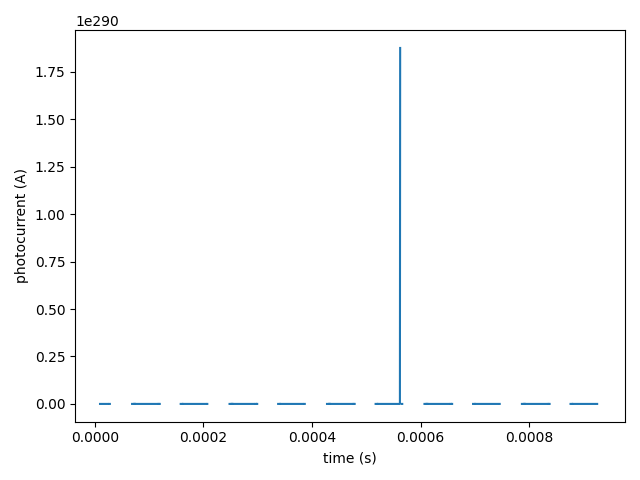

In [ ]:
R = 0.568 #A/W, for standard thorlabs Si photodiode

P_z_t = I_z_t * (np.pi*(beam_diameter/2)**2)
photocurrent_z_t = R*P_z_t

fig,axes=plt.subplots()
axes.plot(t[20:2000],photocurrent_z_t[20:2000])
axes.set_xlabel('time (s)')
axes.set_ylabel('photocurrent (A)')
plt.tight_layout()
plt.show()

# Additional part to point out that something feels wrong there.
<br>
I have N_photons in my system per second, and i have 2N/5 Rb atoms. if we assume a relaxation rate of 2000 (which is pretty low), we have more Rb atoms available per second than photons per second, which corroborate the simulation showing a total absorption. Nevertheless, CSEM's cells have a much higher relaxation rate, higher number of atoms, same laser power and still observe transmitted light. Something is off in what i'm currently doing, but i'm having a hard time finding what. 

In [ ]:
P = 0.2e-3
N = n*V
N_photon = P*795e-9/(h*c)
print('N_photon = {:.2E}'.format(N_photon))

N_photon = 8.00E+14


In [ ]:
print('N = {:.2E}'.format(2/5*N))

N = 4.46E+11


# Sources



[1] : 'How to build a magnetometer with thermal atomic vapor: a tutorial', A. Fabricant, I. Novikova, G. Bison. <br>
[2] : 'Rubidium 87 D Line Data', Daniel A. Steck <br>
[3] : "In-situ measurement and close-loop control of atomic number density in an optically pumped magnetometer based on light absorption", ZiaoLiu et al 2023